В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')

In [3]:
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [4]:
df['Exited'].value_counts()

0.0    11948
1.0     3052
Name: Exited, dtype: int64

In [5]:
train, validation = train_test_split(df, test_size=0.20, random_state=42, stratify=df['Exited'])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [6]:
input_cols = list(df.columns)
input_cols.remove('Exited')
target_col = 'Exited'

In [7]:
train_inputs = train[input_cols].copy()
train_targets = train[target_col].copy()

val_inputs = validation[input_cols].copy()
val_targets = validation[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [9]:
numeric_cols

['id',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [10]:
categorical_cols

['Surname', 'Geography', 'Gender']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

а. Перевіримо нульові значенння в датасеті

In [11]:
train_inputs.isnull().sum(axis = 0)

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [12]:
df.isnull().sum(axis = 0)

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Як бачимо в нашому датасеті немає нульових значень, і це чудово, бо непотрібно їх заповнювати.

б. Подивимось на категоріальні колонки:

In [13]:
df['Surname'].value_counts()

Ch'iu      252
Ch'ien     241
Ch'ang     225
Hsia       204
T'ien      187
          ... 
Trejo        1
Purdy        1
Otoole       1
Sarratt      1
Liardet      1
Name: Surname, Length: 764, dtype: int64

In [14]:
df[df['Surname'] == "Ch'iu"]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
54,54,15743817.0,Ch'iu,735.0,France,Male,37.0,4.0,0.0,2.0,1.0,1.0,142331.85,0.0
124,124,15803562.0,Ch'iu,850.0,Spain,Female,34.0,4.0,0.0,2.0,1.0,0.0,144870.28,0.0
155,155,15780961.0,Ch'iu,762.0,France,Male,38.0,2.0,0.0,1.0,1.0,0.0,77906.87,0.0
303,303,15702541.0,Ch'iu,668.0,France,Male,41.0,10.0,0.0,2.0,1.0,0.0,91086.73,0.0
314,314,15585047.0,Ch'iu,645.0,France,Female,35.0,8.0,0.0,1.0,1.0,0.0,142039.67,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14655,14655,15745452.0,Ch'iu,591.0,Spain,Male,36.0,6.0,0.0,2.0,1.0,1.0,121504.18,0.0
14843,14843,15572408.0,Ch'iu,661.0,Spain,Male,46.0,1.0,0.0,1.0,0.0,1.0,57876.05,1.0
14898,14898,15792726.0,Ch'iu,806.0,France,Male,30.0,6.0,0.0,2.0,0.0,0.0,94670.77,0.0
14985,14985,15754084.0,Ch'iu,681.0,France,Male,28.0,8.0,0.0,2.0,1.0,0.0,189392.66,0.0


Можливо між Surname і відтоком можлива якась залежність, це могли би бути усі члени однієї сім'ї, але дивлячись на прізвище "Ch'iu" воно так не виглядає, тому не бачу сенсу використовувати цю колонку, щоб намагатись побачити залежність між прізвищем та відтоком клієнта.

In [15]:
df.drop('Surname', axis=1, inplace=True)

In [16]:
df['Geography'].value_counts()

France     9032
Spain      3303
Germany    2665
Name: Geography, dtype: int64

In [17]:
train_inputs['Geography'].value_counts()

France     7211
Spain      2638
Germany    2151
Name: Geography, dtype: int64

In [18]:
frequency_encoding = train_inputs['Geography'].value_counts(normalize=True)

# Кодуємо Geography за допомогою частоти
df['Geography_encoded'] = df['Geography'].map(frequency_encoding)

In [19]:
frequency_encoding

France     0.600917
Spain      0.219833
Germany    0.179250
Name: Geography, dtype: float64

In [20]:
df['Geography_encoded']

0        0.600917
1        0.600917
2        0.600917
3        0.179250
4        0.179250
           ...   
14995    0.600917
14996    0.600917
14997    0.600917
14998    0.219833
14999    0.600917
Name: Geography_encoded, Length: 15000, dtype: float64

Колонка 'Gender'

In [21]:
train_inputs['Gender'].value_counts()

Male      6876
Female    5124
Name: Gender, dtype: int64

In [22]:
# Кодуємо Gender

gender_codes = {'Male': 1, 'Female': 0}
df['Gender_Type_Code'] = df['Gender'].map(gender_codes)

Видалимо категоріальні колонки Gender і Geography, які ми вже закодували

In [23]:
df.drop(['Gender', 'Geography'], axis=1, inplace=True)

Подивимось на числові колонки

In [24]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_encoded,Gender_Type_Code
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.569146e+07,658.944133,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667,117784.666193,0.203467,0.442086,0.568600
std,4330.271354,1.352050e+05,72.255926,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910,45734.445888,0.402590,0.195815,0.495288
min,0.000000,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.179250,0.000000
25%,3749.750000,1.563514e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83058.140000,0.000000,0.219833,0.000000
50%,7499.500000,1.569018e+07,662.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123584.870000,0.000000,0.600917,1.000000
75%,11249.250000,1.575718e+07,708.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000,156884.705000,0.000000,0.600917,1.000000
max,14999.000000,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000,1.000000,0.600917,1.000000


Колонки id та CustomerId будемо видаляти, бо в колонці id взагалі немає ніякого сенсу, а для того щоб використовувати CustomerId, потрібно трансформувати увесь датасет і дивитись на нього тільки в розрізі останньої події кастомера або кумулятивно збирати всю активність по ньому.

In [25]:
df.drop(['id', 'CustomerId'], axis=1, inplace=True)

In [26]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_encoded,Gender_Type_Code
0,678.0,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0,0.600917,1
1,687.0,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0,0.600917,0
2,682.0,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0,0.600917,0
3,753.0,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0,0.179250,1
4,544.0,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0,0.179250,0
...,...,...,...,...,...,...,...,...,...,...,...
14995,585.0,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0,0.600917,1
14996,678.0,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0,0.600917,1
14997,678.0,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0,0.600917,0
14998,705.0,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0,0.219833,0


Після усіх обробок, які ми зробили попередньо, ще раз сформуємо навчальний і валідаційний датасети.

In [27]:
train, validation = train_test_split(df, test_size=0.20, random_state=42, stratify=df['Exited'])

In [28]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_encoded,Gender_Type_Code
7180,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,0.0,0.600917,1
10393,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,0.0,0.600917,0
80,705.0,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,0.179250,1
3365,669.0,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0,0.219833,1
12236,707.0,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,0.0,0.600917,1
...,...,...,...,...,...,...,...,...,...,...,...
9493,633.0,33.0,4.0,0.00,2.0,0.0,0.0,123537.05,0.0,0.600917,0
8463,673.0,40.0,1.0,0.00,1.0,1.0,1.0,47832.82,0.0,0.600917,0
8143,621.0,29.0,8.0,0.00,2.0,1.0,1.0,133535.29,0.0,0.600917,1
11512,590.0,42.0,7.0,0.00,2.0,0.0,0.0,72643.95,0.0,0.219833,1


In [29]:
input_cols = list(df.columns)
input_cols.remove('Exited')
target_col = 'Exited'

In [30]:
input_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_encoded',
 'Gender_Type_Code']

In [31]:
train_inputs = train[input_cols].copy()
train_targets = train[target_col].copy()

val_inputs = validation[input_cols].copy()
val_targets = validation[target_col].copy()

Масштабування числових ознак StandardScaler()

In [32]:
scaler = StandardScaler()
scaler.fit(train_inputs)

scaled_train = pd.DataFrame(scaler.transform(train_inputs))
scaled_train.columns = list(train_inputs.columns)
scaled_val = pd.DataFrame(scaler.transform(val_inputs))
scaled_val.columns = list(val_inputs.columns)

In [33]:
scaled_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,Gender_Type_Code
0,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,0.813211,0.863250
1,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,0.813211,-1.158413
2,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,-1.338565,0.863250
3,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,-1.131467,0.863250
4,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,0.813211,0.863250
...,...,...,...,...,...,...,...,...,...,...
11995,-0.357246,-0.576046,-0.368848,-0.717950,0.769304,-1.941514,-0.983306,0.121626,0.813211,-1.158413
11996,0.195761,0.284106,-1.447264,-0.717950,-1.108193,0.515062,1.016977,-1.539006,0.813211,-1.158413
11997,-0.523147,-1.067561,1.069040,-0.717950,0.769304,0.515062,1.016977,0.340946,0.813211,0.863250
11998,-0.951727,0.529864,0.709568,-0.717950,0.769304,-1.941514,-0.983306,-0.994754,-1.131467,0.863250


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [34]:
scaled_train.to_parquet('bank-customer-churn-train-test-data/train_inputs.parquet')
scaled_val.to_parquet('bank-customer-churn-train-test-data/val_inputs.parquet')

In [35]:
pd.DataFrame(train_targets).to_parquet('bank-customer-churn-train-test-data/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('bank-customer-churn-train-test-data/val_targets.parquet')

In [36]:
os.listdir('bank-customer-churn-train-test-data')

['log_reg.joblib',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [37]:
X_train = pd.read_parquet('bank-customer-churn-train-test-data/train_inputs.parquet')
X_val = pd.read_parquet('bank-customer-churn-train-test-data/val_inputs.parquet')

y_train = pd.read_parquet('bank-customer-churn-train-test-data/train_targets.parquet')[target_col]
y_val = pd.read_parquet('bank-customer-churn-train-test-data/val_targets.parquet')[target_col]

In [38]:
model = LogisticRegression(solver='liblinear')

In [39]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [40]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [41]:
confusion_matrix(y_train, train_preds)

array([[9144,  414],
       [1179, 1263]], dtype=int64)

In [42]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 86.72%


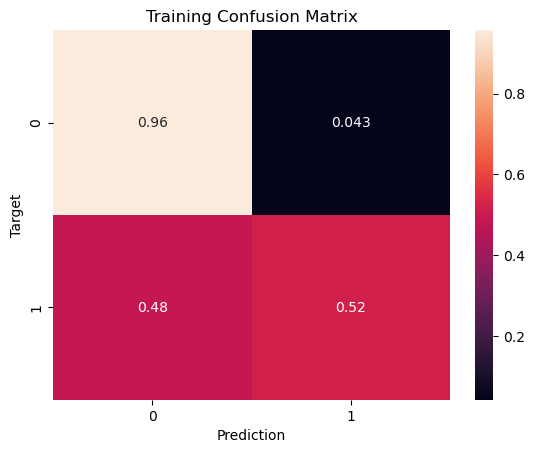

In [43]:
train_preds = predict_and_plot(X_train, y_train, 'Training')

Accuracy: 86.73%


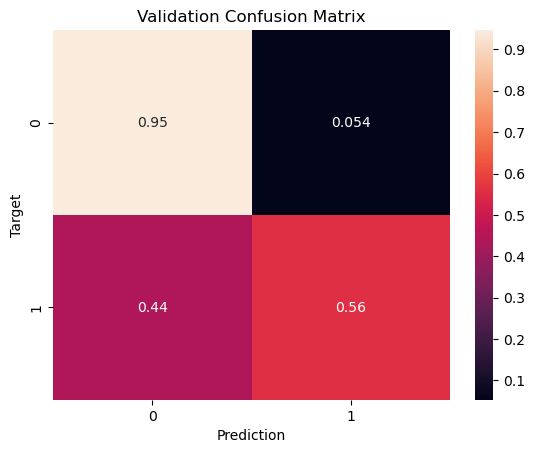

In [44]:
val_preds = predict_and_plot(X_val, y_val, 'Validation')

In [45]:
def get_f1_score(inputs, targets, name=''):
    preds = model.predict(inputs)

    f1_score_ = f1_score(targets, preds, pos_label=1)
    print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, y_train, 'Training')
get_f1_score(X_val, y_val, 'Validation')

F1 score Training: 0.61%
F1 score Validation: 0.63%


In [46]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

AUROC for Training: 0.87


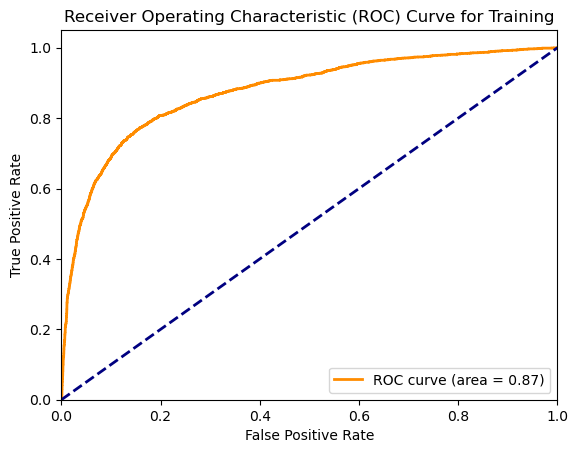

AUROC for Validation: 0.87


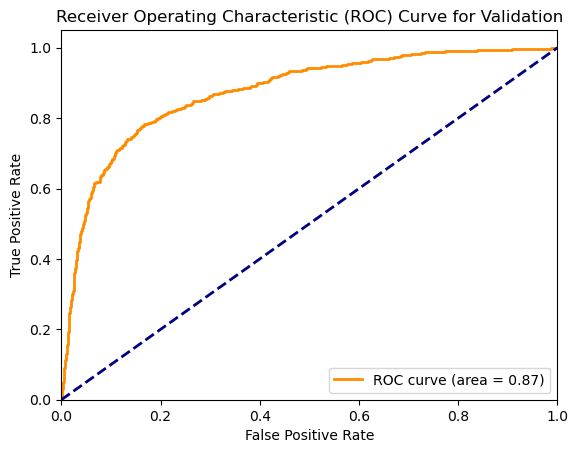

In [47]:
compute_auroc_and_build_roc(X_train, y_train, 'Training')
compute_auroc_and_build_roc(X_val, y_val, 'Validation')

Висновок:
- f1-score має високий показник, а саме 63% на валідаційному датасеті, що вказує на досить непогану якість моделі.
- Так само AUROC має показники у 87%, що вказує на гарну якість.
- Також різниця між показниками метрик на навчальному і валідаційному датасетах невелика, а це означає, що немає перенавчання.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [49]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [51]:
print("Accuracy train dataset, all false model:", accuracy_score(y_train, all_no(y_train)))
print("Accuracy validation dataset, all false model:", accuracy_score(y_val, all_no(y_val)))

Accuracy train dataset, all false model: 0.7965
Accuracy validation dataset, all false model: 0.7966666666666666


In [52]:
print("Accuracy train dataset, logistic regression model:", accuracy_score(y_train, train_preds))
print("Accuracy validation dataset, logistic regression model:", accuracy_score(y_val, val_preds))

Accuracy train dataset, logistic regression model: 0.86725
Accuracy validation dataset, logistic regression model: 0.8673333333333333


Модель, де усі передбачення дорівнюють значенню No досягає точності майже в 80%. Модель логістичної легрессії краща за "дурну" модель і має точність майже 87% на валідаційних даних.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [53]:
log_reg_bank_churn = {
    'model': model,
    'scaler': scaler,
    'input_cols': input_cols,
    'target_col': target_col,
    'frequency_encoding': frequency_encoding,
    'gender_codes': gender_codes
}

In [54]:
joblib.dump(log_reg_bank_churn, 'bank-customer-churn-train-test-data/log_reg.joblib')
model_2 = joblib.load('bank-customer-churn-train-test-data/log_reg.joblib')

In [55]:
model_2

{'model': LogisticRegression(solver='liblinear'),
 'scaler': StandardScaler(),
 'input_cols': ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary',
  'Geography_encoded',
  'Gender_Type_Code'],
 'target_col': 'Exited',
 'frequency_encoding': France     0.600917
 Spain      0.219833
 Germany    0.179250
 Name: Geography, dtype: float64,
 'gender_codes': {'Male': 1, 'Female': 0}}

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
#     input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
#     input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
#     X_input = input_df[numeric_cols + encoded_cols]
#     prob = model.predict_proba(X_input)[:,1]
#     return prob

In [56]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, frequency_encoding, gender_codes, input_cols, model, input_df):
    # Кодуємо Gender
    input_df['Gender_Type_Code'] = input_df['Gender'].map(gender_codes)
    
     # Кодуємо Geography за допомогою частоти
    input_df['Geography_encoded'] = input_df['Geography'].map(frequency_encoding)
    
    input_df[input_cols] = scaler.transform(input_df[input_cols])
    
    X_input = input_df[input_cols]
    prob = model.predict_proba(X_input)[:,1]

    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [57]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv')

In [58]:
model_2['model']

LogisticRegression(solver='liblinear')

In [59]:
model_2['input_cols']

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_encoded',
 'Gender_Type_Code']

In [61]:
test_raw_df['Exited'] = predict_raw_df(model_2['scaler'],
                                       model_2['frequency_encoding'],
                                       model_2['gender_codes'], 
                                       model_2['input_cols'], 
                                       model_2['model'], 
                                       test_raw_df)

In [62]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Type_Code,Geography_encoded,Exited
0,15000,15594796.0,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.86325,-1.338565,0.045717
1,15001,15642821.0,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,0.86325,0.813211,0.029592
2,15002,15716284.0,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,0.86325,0.813211,0.136763
3,15003,15785078.0,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.86325,-1.131467,0.278979
4,15004,15662955.0,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.86325,-1.131467,0.088958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,-0.274295,Spain,Male,0.038348,1.787983,-0.717950,0.769304,0.515062,1.016977,-1.499416,0.86325,-1.131467,0.035098
9996,24996,15739271.0,Clements,0.264887,Spain,Male,0.161227,1.428511,-0.717950,0.769304,0.515062,1.016977,0.537890,0.86325,-1.131467,0.041261
9997,24997,15756743.0,Chidiebere,1.592102,France,Male,-0.944682,1.428511,-0.717950,0.769304,0.515062,-0.983306,-2.481612,0.86325,0.813211,0.015037
9998,24998,15680167.0,Yermakova,-0.882602,France,Male,0.038348,0.350096,1.700511,-1.108193,0.515062,-0.983306,0.185943,0.86325,0.813211,0.229435


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [63]:
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')

In [64]:
sample_submission = pd.merge(sample_submission,
                             test_raw_df[['id', 'Exited']],
                             on='id',
                             how='left',
                             suffixes=('_new', ''))

In [65]:
sample_submission.drop(columns=['Exited_new'], inplace=True)

In [66]:
sample_submission.head()

,id,Exited
0,15000,0.045717
1,15001,0.029592
2,15002,0.136763
3,15003,0.278979
4,15004,0.088958


In [67]:
sample_submission[sample_submission['Exited'] > 0.5]

,id,Exited
11,15011,0.953223
22,15022,0.938222
25,15025,0.611273
26,15026,0.571195
29,15029,0.530843
...,...,...
9970,24970,0.722482
9986,24986,0.847030
9989,24989,0.658744
9990,24990,0.857983


In [68]:
sample_submission.to_csv('bank-customer-churn-prediction-dlu/submission_log_reg.csv', index=False)